Customer Sentiment Analysis for logistic sector.

In [1]:
%matplotlib inline

import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import csv
import nltk
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np, pylab as pl
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from stemming.porter import stem

Word detection function

In [3]:
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

Function to convert a raw text to a string of words. The input is a single string (a raw text), and the output is a single string (a preprocessed text).

1. Remove non-letters.
2. Convert to lower case, split into individual words
3. In Python, searching a set is much faster than searching a list, so convert the stop words to a set.
4. Remove stop words
5. Stemming (english)
6. Join the words back into one string separated by space and return the result.

In [4]:
def review_to_words( raw_review ):  
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))    
    meaningful_words = [w for w in words if not w in stops]  
    filtered_words = [stem(word) for word in meaningful_words if word not in stops]
    return( " ".join( filtered_words ))

Read tweeter data

In [5]:
tweets_data_path = 'data/twitter_final_data.txt'
with open(tweets_data_path) as file:
    tweets_data = json.load(file)

Print number of tweets

In [6]:
print len(tweets_data)

498


Structure the tweets data into a pandas DataFrame to simplify the data manipulation.

In [7]:
tweets = pd.DataFrame()

Add e columns to the tweets DataFrame called text, where text column contains the tweet,

In [8]:
tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)
tweets['sentiment'] = map(lambda tweet: tweet['sentiment'], tweets_data)

Read first tweet.

In [9]:
print tweets['text'][0]

RT @mackenzie_nolin: The mail man pulled out his pepper spray on my dog that was sat wagging her tail excited to see him.. #USPS


Remove punctuation and numbers

In [10]:
print stopwords.words("english")

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

Show top 5 languages in which the tweets were written.

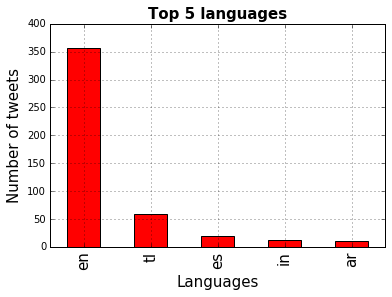

In [11]:
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

Show top 5 countries from which the tweets were sent.

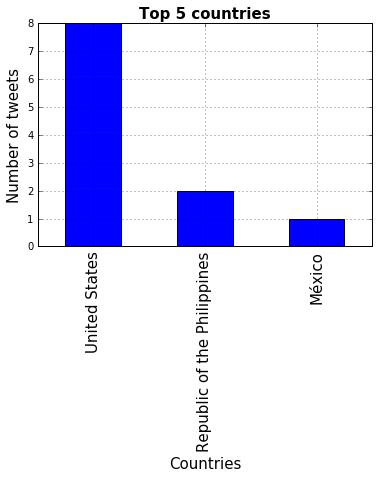

In [12]:
tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

Add 3 columns to our tweets DataFrame.

In [13]:
tweets['dhl'] = tweets['text'].apply(lambda tweet: word_in_text('dhl', tweet))
tweets['usps'] = tweets['text'].apply(lambda tweet: word_in_text('usps', tweet))
tweets['fedex'] = tweets['text'].apply(lambda tweet: word_in_text('fedex', tweet))

Calculate the number of tweets for each companies as follows:

In [14]:
print tweets['dhl'].value_counts()[True]
print tweets['usps'].value_counts()[True]
print tweets['fedex'].value_counts()[True]

134
113
188


Make a simple comparaison chart by executing the following:

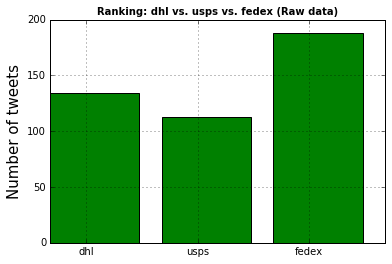

In [15]:
prg_langs = ['dhl', 'usps', 'fedex']
tweets_by_prg_lang = [tweets['dhl'].value_counts()[True], tweets['usps'].value_counts()[True], tweets['fedex'].value_counts()[True]]

x_pos = list(range(len(prg_langs)))
width = 0.8
fig, ax = plt.subplots()
plt.bar(x_pos, tweets_by_prg_lang, width, alpha=1, color='g')

ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: dhl vs. usps vs. fedex (Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.4 * width for p in x_pos])
ax.set_xticklabels(prg_langs)
plt.grid()

In [16]:
clean_review = review_to_words( tweets["text"][0] )

print "Comparision..."
print tweets["text"][0]
print clean_review

Comparision...
RT @mackenzie_nolin: The mail man pulled out his pepper spray on my dog that was sat wagging her tail excited to see him.. #USPS
rt mackenzi nolin mail man pull pepper sprai dog sat wagg tail excit see usp


Get the number of texts based on the dataframe column size. Initialize an empty list to hold the clean texts. Loop over each tex and create an index i that goes from 0 to the length of the list. Call our function for each one, and add the result to the list of clean texts.

In [17]:
num_texts = tweets["text"].size
clean_train_reviews = []

for i in xrange( 0, num_texts ):
    clean_train_reviews.append( review_to_words( tweets["text"][i] ) )

Using the feature_extraction module from scikit-learn to create bag-of-words features. Initialize the "CountVectorizer" object, which is scikit-learn's bag of words tool. fit_transform() does two functions: First, it fits the model and learns the vocabulary; second, it transforms our training data into feature vectors. The input to fit_transform should be a list of strings. Numpy arrays are easy to work with, so convert the result to an array.

In [18]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

train_data_features = vectorizer.fit_transform(clean_train_reviews)
train_data_features = train_data_features.toarray()

Show see what the training data array now looks like

In [19]:
print train_data_features.shape

(498, 2325)


Take a look at the words in the vocabulary

In [20]:
vocab = vectorizer.get_feature_names()
print vocab

[u'aan', u'abcdefutbol', u'abdilo', u'abl', u'ablegt', u'absa', u'accept', u'accompani', u'accord', u'account', u'accus', u'acneeczyrk', u'acropolitess', u'act', u'activ', u'acwmagazin', u'address', u'adik', u'administr', u'aduana', u'advanc', u'advantag', u'advisor', u'affai', u'affect', u'afrkuuyqm', u'ag', u'agad', u'agenda', u'agenta', u'ago', u'agreatercountri', u'ahead', u'ahora', u'ahzhen', u'aid', u'air', u'airandground', u'akhtxm', u'ako', u'akong', u'al', u'alam', u'alamancedrumm', u'aldenupsurgeonsnbo', u'aldi', u'alexandr', u'alfayroooz', u'alhanen', u'ali', u'allaskiv', u'allegedli', u'allow', u'alm', u'almondscentedbathsoap', u'alon', u'also', u'alwayzwright', u'alwi', u'amaz', u'amazon', u'amazonhelp', u'ambctodai', u'amen', u'america', u'american', u'amid', u'amin', u'amor', u'amp', u'ampc', u'amsnyde', u'amtrak', u'andrew', u'ang', u'angelciraq', u'angelish', u'aniroc', u'annybkoi', u'anonitgo', u'anonym', u'anoth', u'anyone', u'anyth', u'apa', u'appar', u'applianc', u

Sum up the counts of each vocabulary word. For each, print the vocabulary word and the number of times it appears in the training set. Print the counts of each word in the vocabulary

In [21]:
dist = np.sum(train_data_features, axis=0)

for tag, count in zip(vocab, dist):
    print count, tag

1 aan
1 abcdefutbol
1 abdilo
2 abl
1 ablegt
1 absa
1 accept
1 accompani
1 accord
1 account
2 accus
1 acneeczyrk
1 acropolitess
4 act
1 activ
2 acwmagazin
3 address
2 adik
2 administr
2 aduana
1 advanc
1 advantag
1 advisor
1 affai
1 affect
1 afrkuuyqm
2 ag
1 agad
1 agenda
1 agenta
1 ago
1 agreatercountri
2 ahead
12 ahora
1 ahzhen
1 aid
1 air
1 airandground
1 akhtxm
6 ako
1 akong
3 al
1 alam
1 alamancedrumm
1 aldenupsurgeonsnbo
1 aldi
1 alexandr
2 alfayroooz
2 alhanen
2 ali
2 allaskiv
1 allegedli
1 allow
2 alm
1 almondscentedbathsoap
3 alon
1 also
3 alwayzwright
1 alwi
2 amaz
5 amazon
4 amazonhelp
3 ambctodai
1 amen
1 america
3 american
1 amid
1 amin
1 amor
27 amp
3 ampc
1 amsnyde
2 amtrak
2 andrew
27 ang
10 angelciraq
1 angelish
3 aniroc
2 annybkoi
1 anonitgo
1 anonym
2 anoth
8 anyone
1 anyth
1 apa
2 appar
2 applianc
1 appreciat
1 apt
5 aq
1 ar
2 aramex
2 araw
2 area
1 argueda
3 around
6 arriv
1 art
1 asdtjm
1 asegurado
1 asgard
1 ashlloyd
3 ask
1 assist
7 aston
1 aszzooi
1 at
12 atenc


Use the Random Forest classifier. Initialize a Random Forest classifier with 100 trees. Fit the forest to the training set, using the bag of words as features and the sentiment labels as the response variable. This may take a few minutes to run.

In [22]:
print "Training the random forest..."

forest = RandomForestClassifier(n_estimators = 100) 
forest = forest.fit( train_data_features, tweets["sentiment"] )

Training the random forest...


Read the test data. Create an empty list and append the clean tweets one by one. Get a bag of words for the test set, and convert to a numpy array. Use the random forest to make sentiment label predictions. Copy the results to a pandas dataframe with an "id" column and a "sentiment" column. Use pandas to write the comma-separated output file.

In [26]:
test = pd.read_csv("data/testData.tsv", header=0, delimiter="\t", \
                   quoting=3 )

print test.shape

num_texts = len(test["text"])
clean_test_reviews = [] 

print "Cleaning and parsing the test set...\n"
for i in xrange(0,num_texts):
    if( (i+1) % 1000 == 0 ):
        print "Text %d of %d\n" % (i+1, num_texts)
    clean_review = review_to_words( test["text"][i] )
    clean_test_reviews.append( clean_review )

test_data_features = vectorizer.transform(clean_test_reviews)
test_data_features = test_data_features.toarray()

result = forest.predict(test_data_features)

output = pd.DataFrame( data={"id":test["id"], "sentiment":result} )
output.to_csv( "data/Bag_of_Words_model.csv", index=False, quoting=3 )

(168, 2)
Cleaning and parsing the test set...

